<a class="anchor" id="top"></a>

# Topic Modeling with LDA to Generate Target Risk Topics
Author: Ainesh Pandey

In this notebook, we will perform topic modeling using [LDA (Latent Dirichlet Allocation)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) on the _Lesson(s) Learned_ column of the `lessons_learned.csv` dataframe. The purpose of this analysis is to attempt to organize the different projects into risk topics. Assuming the LDA model produces reasonable topics, we can use the topic classification as ground truth in a modeling objective.

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Text Preprocessing](#step-2) <br>
[Step 3: Tuning Number of Topics](#step-3) <br>
[Step 4: Categorization and Results Visualization](#step-4) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
# basic data science packages
import pandas as pd
import numpy as np
from operator import itemgetter
np.random.seed(5)

# gensim packages for text preprocessing and LDA
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

# nltk packages for text preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

# visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ainesh93/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ainesh93/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<a class="anchor" id="step-2"></a>

### Data
We import `lessons_learned.csv` and keep only information from the _Lesson(s) Learned_ column.

In [2]:
df = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv',
                 usecols=['Lesson ID', 'Lesson(s) Learned'])
df = df[df['Lesson(s) Learned'].notna()]

display(df.shape)
df.iloc[244:248,]

(2086, 2)

,Lesson ID,Lesson(s) Learned
244,3636,One group is in charge of O&M and another grou...
246,4256,Proper maintenance of equipment and training o...
247,4056,Having the FCP obtain the electrical power it ...
248,4218,When dealing with a component in a semi-closed...


<a class="anchor" id="step-2"></a>

## Text Preprocessing

First, we develop the prepocessing function that:
- calls the `gensim` *simple_preprocess* function
- removes stopwords and words shorter than three letters
- stems and lemmatizes the words

In [5]:
def preprocess(text):
    stemmer = PorterStemmer()
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')))
    return result

processed_lessons = df['Lesson(s) Learned'].map(preprocess)

print('Original text')
print(df.iloc[0,1])
print()
print('Processed text')
print(processed_lessons[:1][0])

Original text
Approach 1 made it difficult to understand the complete risk profile of the project because risks were split between the contractor and the government risk registers. Subsequently, approach 2 provided greater ongoing awareness to the risks owned by the contractor; however, it did not result in significant improvement to the government mitigation of those risks. Disagreements on the assessment, handling, or closure of risks owned by the contractor were at times strained. Finally, approach 3 placed the responsibility on the government to identify, track, and assess handling plans for all risks to the project, utilizing the contractor process more as a source of information rather than the responsible authority for instrument development risk management. This change resulted in an increase to Government tracked risks but allowed the government to better manage and understand the project risk posture.

Processed text
['approach', 'difficult', 'understand', 'complet', 'risk', 

Next, we need to create the data structures required by the LDA package.
- dictionary: contains all of the post-processed terms in the corpus, subject to certain conditions
- corpus_bow: a bag-of-words representation of each document
- corpus_tfidf: converts the bag-of-words representation into a TFIDF (term-frequency-inverse-document-frequency) representation

In [8]:
# create dictionary, keep only terms that occur less than 10 times and in less than half of the documents, keeping a max of 100000 terms
dictionary = gensim.corpora.Dictionary(processed_lessons)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# create the corpus_bow
corpus_bow = [dictionary.doc2bow(doc) for doc in processed_lessons]

# create the corpus_tfidf
tfidf_model = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf_model[corpus_bow]

# display the first document
print('Original text')
print(df.iloc[0,1])
print()

# visualize the first 5 elements of the corpus_bow for the first document
print('Bag-of-words Representation')
print(corpus_bow[0])
print()

# visualize the tfidf representation of the first document
print('TF-IDF Representation')
print(corpus_tfidf[0])

Original text
Approach 1 made it difficult to understand the complete risk profile of the project because risks were split between the contractor and the government risk registers. Subsequently, approach 2 provided greater ongoing awareness to the risks owned by the contractor; however, it did not result in significant improvement to the government mitigation of those risks. Disagreements on the assessment, handling, or closure of risks owned by the contractor were at times strained. Finally, approach 3 placed the responsibility on the government to identify, track, and assess handling plans for all risks to the project, utilizing the contractor process more as a source of information rather than the responsible authority for instrument development risk management. This change resulted in an increase to Government tracked risks but allowed the government to better manage and understand the project risk posture.

Bag-of-words Representation
[(0, 1), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1

<a class="anchor" id="step-3"></a>

## Tuning Number of Topics

Identifying the ideal number of topics is a key step of LDA. We will test different number of topics through brute-force, using a coherence value to identify how distinct the different topics are for each iteration. We will start with two (2) topics, and test up to twenty (20) topics.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = [0 for n in range(start)]

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, chunksize=100,
                                           random_state=10, passes=10, workers=4, per_word_topics=True)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print('Done modeling for num_topics = {}, Coherence score: {}'.format(num_topics, coherencemodel.get_coherence()))

    return coherence_values

coherence_values = compute_coherence_values(dictionary, corpus_tfidf, processed_lessons, 21, start=2, step=1)

Done modeling for num_topics = 2, Coherence score: 0.365314921604133
Done modeling for num_topics = 3, Coherence score: 0.35469365756252813
Done modeling for num_topics = 4, Coherence score: 0.3251668052296689
Done modeling for num_topics = 5, Coherence score: 0.46789338841512196
Done modeling for num_topics = 6, Coherence score: 0.473738849228824
Done modeling for num_topics = 7, Coherence score: 0.37847530432383886
Done modeling for num_topics = 8, Coherence score: 0.3767399797500378
Done modeling for num_topics = 9, Coherence score: 0.4775377573233662
Done modeling for num_topics = 10, Coherence score: 0.49066925673976874
Done modeling for num_topics = 11, Coherence score: 0.4519339300635648
Done modeling for num_topics = 12, Coherence score: 0.47784301234405674
Done modeling for num_topics = 13, Coherence score: 0.45310483989191136
Done modeling for num_topics = 14, Coherence score: 0.536526351878292
Done modeling for num_topics = 15, Coherence score: 0.49344287969184747
Done model

An accepted practice used to identify the number of topics is the "elbow method". We will visualize the coherence scores across number of topics to identify the elbow.

In [17]:
# Show graph
limit=21; step=1
# x = range(0, limit, step)
plt.plot(range(0, limit, step), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

NameError: name 'coherence_values' is not defined

According to the graph, the "elbow" is at 5 topics. However, there is another max at 14 topics as well. We will create both models and try to visualize topics to identify if one approach is better than the other.

In [9]:
model_5topics = gensim.models.LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=5, chunksize=100,
                                           random_state=10, passes=10, workers=4, per_word_topics=True)

<a class="anchor" id="step-4"></a>

## Categorization and Results Visualization

We now categorize each lesson learned into one of the 5 topics.

In [10]:
df['Topic']  = [max(model_5topics[corpus_tfidf[n]][0], key=itemgetter(1))[0] for n in range(len(corpus_tfidf))]

display(df.shape)
df.head()

(2086, 3)

,Lesson ID,Lesson(s) Learned,Topic
0,30004,Approach 1 made it difficult to understand the...,4
1,30101,As a result of many years of expensive lessons...,4
2,29801,There was an unexpectedly wide variation in el...,4
3,29702,"If possible, the design phase of both systems ...",4
4,29103,The pinch was initially visually inspected and...,4


Let's first visualize the distribution of the topics.

4    1542
0     486
2      31
1      17
3      10
Name: Topic, dtype: int64

Text(0.5, 1.0, 'Distribution of Topics')

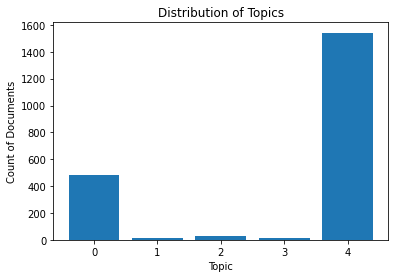

In [48]:
dist = df['Topic'].value_counts()
display(dist)

plt.bar(dist.index, dist)
plt.xlabel("Topic")
plt.ylabel("Count of Documents")
plt.title("Distribution of Topics")

The distribution is very uneven, but this may not necessarily be a bad thing. The inputs used are non-standardized free-text in human English. It is possible that there are very few identifying features for specific risk profiles. We need to further examine the composition of the documents within each topic to see if certain trends emerge.

Let's examine the results of our topic modeling. First, let's view the functions created to calculate the probability of a document from the _Lesson(s) Learned_ column belonging to a certain topic.

In [11]:
for idx, topic in model_5topics.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.017*"damag" + 0.013*"caus" + 0.012*"result" + 0.012*"failur" + 0.011*"pressur" + 0.009*"electr" + 0.009*"injuri" + 0.008*"valv" + 0.008*"personnel" + 0.008*"contamin"
Topic: 1 Word: 0.022*"human" + 0.017*"torqu" + 0.012*"regul" + 0.012*"motor" + 0.012*"satellit" + 0.011*"data" + 0.011*"astronaut" + 0.011*"troubleshoot" + 0.010*"wast" + 0.010*"pilot"
Topic: 2 Word: 0.026*"connector" + 0.013*"solder" + 0.013*"telemetri" + 0.011*"read" + 0.010*"magnet" + 0.010*"nois" + 0.010*"segment" + 0.010*"suit" + 0.010*"fiber" + 0.010*"coat"
Topic: 3 Word: 0.024*"wall" + 0.022*"attach" + 0.019*"thermal" + 0.017*"deterior" + 0.014*"bond" + 0.012*"abort" + 0.011*"degre" + 0.011*"ship" + 0.010*"portabl" + 0.010*"machin"
Topic: 4 Word: 0.009*"test" + 0.007*"project" + 0.007*"design" + 0.007*"oper" + 0.007*"requir" + 0.007*"flight" + 0.006*"mission" + 0.005*"program" + 0.005*"hardwar" + 0.005*"perform"


We may need to access the key terms for each topic. Let's arrange them into a dataframe.

In [12]:
# create the dataframe
df_topic_terms = pd.DataFrame()

# for each of the 5 topics, add their key term indices and coefficients to the dataframe
for topic in range(5):
    temp = pd.DataFrame(model_5topics.get_topic_terms(topic))
    temp['Topic'] = topic
    df_topic_terms = df_topic_terms.append(temp)

# add a column for the term referred to by each term index
df_topic_terms['Term'] = [dictionary[x] for x in df_topic_terms[0]]

# rearrange columns to be more intuitive
df_topic_terms.columns = ['Term Index', 'Term Coefficient', 'Topic', 'Term']
df_topic_terms = df_topic_terms[['Topic', 'Term Index', 'Term', 'Term Coefficient']]

display(df_topic_terms.shape)
df_topic_terms.head()

(50, 4)

,Topic,Term Index,Term,Term Coefficient
0,0,86,damag,0.016723
1,0,63,caus,0.012542
2,0,30,result,0.012439
3,0,129,failur,0.012208
4,0,593,pressur,0.010543


Now, let's visualize the key terms of each topic next to the terms from all of the documents within.

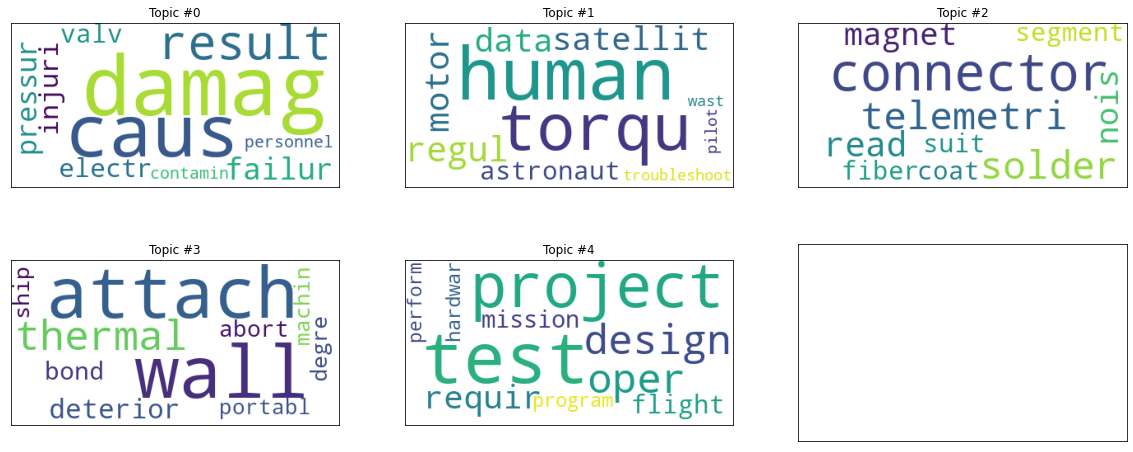

In [14]:
df_topic_terms.index = df_topic_terms['Term']
fig, ax = plt.subplots(2,3, figsize = (20,8))

i, j = 0, 0
for topic in range(5):
    temp_topic = df_topic_terms[df_topic_terms['Topic'] == topic]
    temp_topic_cloud = WordCloud(background_color='white').generate_from_frequencies(temp_topic['Term Coefficient'])
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
    ax[i,j].title.set_text('Topic #{}'.format(topic))
    ax[i,j].imshow(temp_topic_cloud)

    j += 1
    if j > 2:
        j = 0
        i += 1

ax[1,2].axes.xaxis.set_visible(False)
ax[1,2].axes.yaxis.set_visible(False)

We can see certain patterns emerging for each topic.

- Topic 1: The key terms `damag`, `pressur`, `valv`, `contam`, `electr`, `injuri`, and `failur` indicate that the risks associated with this topic are specific to accidents or mistakes happening in the ...
- Topic 2: 

Let's further visualize each topic's wordcloud alongside the wordclouds of all of the documents within that topic.

,Lesson ID,Lesson(s) Learned,Topic
8,28105,In bi-propellant systems there is a risk that ...,0
34,24403,While bird strikes are most typical during lan...,0
46,21803,Egress/ingress ramps without doorway landings ...,0
48,22003,Due to the material stackup in a typical ISIM ...,0
54,18701,From this experience we learned that: Ensuring...,0
57,19501,A crowbar is a fail-safe protection mechanism ...,0
119,6956,Continuing vigilance must be maintained during...,0
133,8016,Clean up technicians were unaware of the conta...,0
231,6142,"In main propulsion systems, the liquid propell...",0
232,6144,Electrical connector integrity can be signific...,0


,Lesson ID,Lesson(s) Learned,Topic
131,8301,The text has been redacted for International T...,1
132,8202,The text has been redacted for International T...,1
485,1781,"Just that backup tapes are seen to move, or ba...",1
597,1533,Homing radio beacon transmitters can lose thei...,1
801,1328,"For incorrect labeling, PRACA would be taken w...",1
838,1307,A satellite simulator is worth the investment.,1
1531,575,Removal of debris or waste must be verified du...,1
1779,209,The SSME telemetry system provides only approx...,1
1822,174,There are no brakes on the bridge bucket drive...,1
1827,179,The full scale hot fire testing of the SRM's w...,1


,Lesson ID,Lesson(s) Learned,Topic
98,12602,See Attached Reports,2
101,6358,"It is preferable to use a simple, easy to read...",2
102,12603,See report,2
250,1917,LEMO connectors are not robust enough for repe...,2
284,6016,See attached report,2
285,5976,See attached report,2
338,3557,"Heavy, cumbersome structural components that a...",2
429,1919,The use of encapsulant in samples processed in...,2
466,1838,See attached report,2
774,1354,Provide a test/migration suite,2


,Lesson ID,Lesson(s) Learned,Topic
5,26803,See attached PDF.,3
190,6344,See attached document,3
191,6347,See attached document,3
192,6345,See attached document,3
193,6349,See attached document,3
318,4496,See attachment,3
387,2596,See attached document,3
416,2049,See quotRecommendation(s)quot,3
837,1308,"Heritage does not mean ""use as is"".",3
972,1161,There is no in-flight crew escape system for t...,3


,Lesson ID,Lesson(s) Learned,Topic
0,30004,Approach 1 made it difficult to understand the...,4
1,30101,As a result of many years of expensive lessons...,4
2,29801,There was an unexpectedly wide variation in el...,4
3,29702,"If possible, the design phase of both systems ...",4
4,29103,The pinch was initially visually inspected and...,4
6,28903,The improvements in K2 operations and science ...,4
7,28101,"Early in the design and development phase, a c...",4
9,28202,The use of preliminary drawings for analysis i...,4
10,28201,Early life cycle qualification of weld paramet...,4
11,27901,When using only (IMU-based) inertial measureme...,4


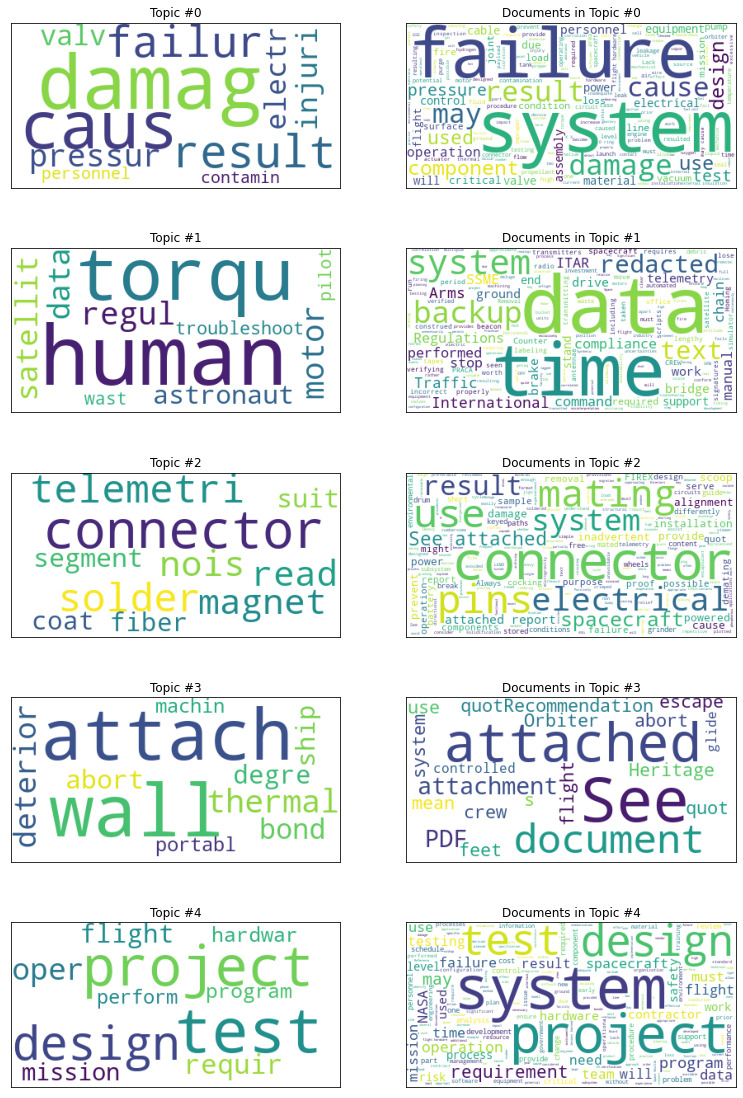

In [50]:
fig, ax = plt.subplots(5,2, figsize = (13,20))

for topic in range(5):
    temp_df = df[df['Topic'] == topic]
    display(temp_df.head(10))
    temp_topic = df_topic_terms[df_topic_terms['Topic'] == topic]
    temp_docs  = ' '.join(temp_df["Lesson(s) Learned"])
    temp_topic_cloud = WordCloud(background_color='white').generate_from_frequencies(temp_topic['Term Coefficient'])
    temp_docs_cloud  = WordCloud(background_color='white').generate(temp_docs)

    ax[topic,0].axes.xaxis.set_visible(False)
    ax[topic,0].axes.yaxis.set_visible(False)
    ax[topic,0].title.set_text('Topic #{}'.format(topic))
    ax[topic,0].imshow(temp_topic_cloud)

    ax[topic,1].axes.xaxis.set_visible(False)
    ax[topic,1].axes.yaxis.set_visible(False)
    ax[topic,1].title.set_text('Documents in Topic #{}'.format(topic))
    ax[topic,1].imshow(temp_docs_cloud)